In [1]:
#basic packages
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

#interpolation
from scipy import interpolate 
#model
from statsmodels.tsa.api import VAR
#classifcation metrics
from sklearn.metrics import f1_score, roc_auc_score, mean_squared_error
#beta diversity
from scipy.spatial import distance
#alpha diveristy metrics
from skbio.diversity.alpha import shannon
#ordination
import skbio
from scipy.spatial import procrustes

sns.set_style("whitegrid")

# READ FILES

In [2]:
TRUE_FAMILY = pd.read_csv('TRUE_FAMILY.csv', index_col = [0])
TRUE_SEQUENCE = pd.read_csv('TRUE_SEQUENCES.csv', index_col = [0], sep = '\t')

#VAR_1_PREDICTION = pd.read_csv('VAR_lag_1_prediction.csv')
VAR_2_PREDICTION = pd.read_csv('VAR_lag_2_prediction.csv', index_col = [0])

sVAR_1_PREDICTION = pd.read_csv('sVAR1_pred.csv', sep = '\t', index_col = [0])
sVAR_2_PREDICTION = pd.read_csv('sVAR2_pred.csv')
sVAR_2_PREDICTION.columns = TRUE_SEQUENCE.columns

NAIVE_FORECAST_FAMILY = pd.read_csv('naive_forecast_family.csv', index_col = [0])
NAIVE_FORECAST_SEQUENCE =  pd.read_csv('naive_forecast_sequence.csv', index_col = [0])

In [4]:
PREDICTIONS = [VAR_1_PREDICTION, VAR_2_PREDICTION, sVAR_1_PREDICTION, sVAR_2_PREDICTION, NAIVE_FORECAST_FAMILY, NAIVE_FORECAST_SEQUENCE]
HISTORY = [TRUE_FAMILY, TRUE_FAMILY, TRUE_SEQUENCE, TRUE_SEQUENCE, TRUE_FAMILY, TRUE_SEQUENCE]
NAMES = ['VAR_LAG1', 'VAR_LAG2', 'sVAR_LAG1', 'sVAR_LAG2', 'NAIVE_FORECAST_FAMILY', 'NAIVE_FORECAST_SEQUENCE']

# BRAY CURTIS

In [5]:
def calculate_BC(HISTORY, PREDICTION, MODEL):
    
    BRAY_CURTIS = []

    for idx in HISTORY.index:

        y_true = HISTORY.loc[idx]
        y_forecasted = PREDICTION.loc[idx]

        bray_curtis = distance.braycurtis(y_true,
                                          y_forecasted)

        BRAY_CURTIS.append(bray_curtis)

    bray_curtis_df = pd.DataFrame(BRAY_CURTIS,
                              columns = ['BC_DISTANCE'])

    bray_curtis_df['timestep'] = HISTORY.index
    bray_curtis_df['MODEL'] = MODEL
    
    return bray_curtis_df

In [6]:
BC = []
for p, h, n in zip(PREDICTIONS, HISTORY, NAMES):
    
    bc = calculate_BC(p, h, n)
    BC.append(bc)
    
BC_EVALUATION = pd.concat(BC)

In [15]:
import matplotlib.patches as mpatches

def plot_evaluation(df, metric, title):
    
    plt.figure(figsize=(12,5))

    ax = sns.boxplot(data = df,
               x = 'MODEL',
               y = metric,
               color = 'white',
               width = 0.5,
               linewidth = 0.9,
               fliersize = 5)

    ax = sns.swarmplot(data = df,
               x = 'MODEL',
               y = metric,
                 palette = 'pastel',
                 size = 4)

    plt.title(title,
              fontsize = 14)
    
    sns.despine(offset=10,
                trim=True)
    
    plt.xticks(rotation=20, fontsize = 10)
    ax.grid(False)
    plt.savefig('{}.png'.format(title), bbox_inches='tight')
    plt.show()

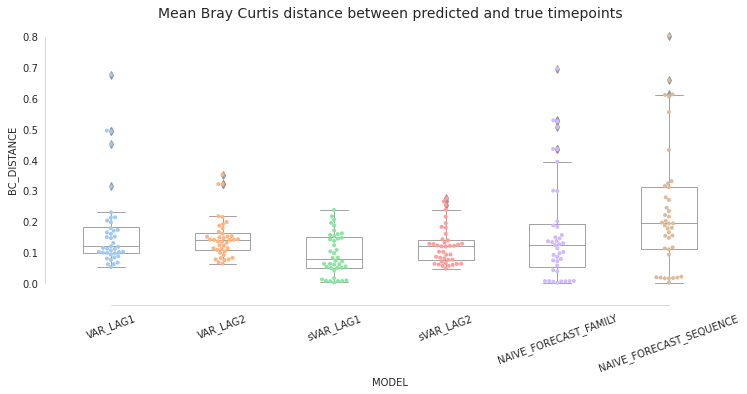

In [16]:
plot_evaluation(BC_EVALUATION, 'BC_DISTANCE', 'Mean Bray Curtis distance between predicted and true timepoints')

In [9]:
def calculate_shannon_mape(PREDICTION, HISTORY, MODEL):
    
    TIMEPOINT = []
    MAPE = []

    for i in TRUE_FAMILY.index:
        TIMEPOINT.append(i)

        TRUE_SHANNON = HISTORY.loc[i]
        FORECASTED_SHANNON = PREDICTION.loc[i]

        true_shannon = shannon(TRUE_SHANNON)
        predicted_shannon = shannon(FORECASTED_SHANNON) 

        mape = np.mean(np.abs((true_shannon - predicted_shannon) / true_shannon)) * 100
        MAPE.append(mape)

    sVAR_shannon = pd.DataFrame(list(zip(TIMEPOINT, MAPE)),
                              columns = ['timepoint', 'SHANNON_MAPE'])
    sVAR_shannon['MODEL'] = MODEL
    
    return sVAR_shannon

In [10]:
SHANNON = []
for p, h, n in zip(PREDICTIONS, HISTORY, NAMES):
    
    shannon_d = calculate_shannon_mape(p, h, n)
    SHANNON.append(shannon_d)
    
SHANNON_EVALUATION = pd.concat(SHANNON)

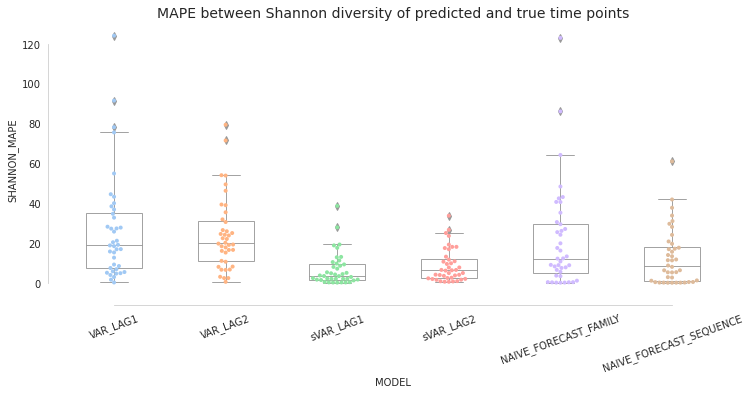

In [17]:
plot_evaluation(SHANNON_EVALUATION, 'SHANNON_MAPE', 'MAPE between Shannon diversity of predicted and true time points')

# nRMSE sor each bacteria

In [3]:
normalised_nRMSE = []
COL = []

for col in VAR_2_PREDICTION.columns.tolist():

    TRUE = TRUE_FAMILY[col]    
    FORECAST = VAR_2_PREDICTION[col]

    divider = TRUE.max() - TRUE.min() #+ 0.00001
    RMSE = mean_squared_error(TRUE, FORECAST, squared=False)
    nRMSE = RMSE/divider

    normalised_nRMSE.append(nRMSE)
    COL.append(col)

nRMSE_COL = pd.DataFrame(list(zip(COL, normalised_nRMSE)), columns = ['BACTERIA', 'NRMSE'])

/tmp/ipykernel_15962/1863983843.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  nRMSE = RMSE/divider


In [4]:
nRMSE_COL = nRMSE_COL[nRMSE_COL['BACTERIA']!='k__Bacteria;p__Verrucomicrobia;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Verrucomicrobiaceae']
nRMSE_COL = nRMSE_COL[nRMSE_COL['BACTERIA']!='k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae']

In [5]:
nRMSE_COL = nRMSE_COL.sort_values(by = ['NRMSE'])

In [6]:
time_normalised_nRMSE = []
TIMESTEP = []

for i in VAR_2_PREDICTION.index:

    TRUE = TRUE_FAMILY.loc[i]    
    FORECAST = VAR_2_PREDICTION.loc[i]

    RMSE = mean_squared_error(TRUE, FORECAST, squared=False)
    div =  (TRUE_FAMILY.loc[i].max() - TRUE_FAMILY.loc[i].min())
    nRMSE = RMSE/div
    time_normalised_nRMSE.append(nRMSE)
    TIMESTEP.append(i)

nRMSE_TIME = pd.DataFrame(list(zip(TIMESTEP, time_normalised_nRMSE)), columns = ['TIMESTEP', 'NRMSE'])
#nRMSE_TIME = nRMSE_TIME.sort_values(by = ['NRMSE'])

In [7]:
heatmap_nrmse = pd.DataFrame(columns = ['nRMSE_bacterial_familywise', 'nRMSE_timestepwise'])
heatmap_nrmse['nRMSE_timestepwise'] = nRMSE_TIME['NRMSE']
heatmap_nrmse['nRMSE_bacterial_familywise'] = nRMSE_COL['NRMSE']

heatmap_nrmse = heatmap_nrmse.reset_index().drop(['index'], axis = 1)

<Figure size 720x720 with 0 Axes>

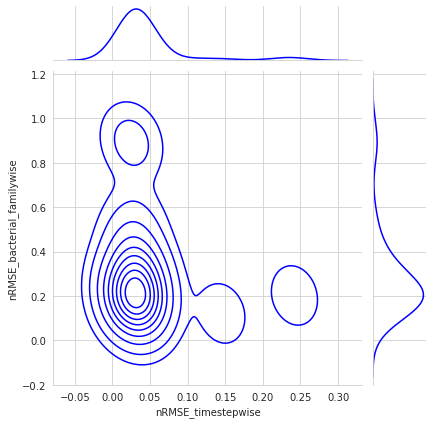

In [8]:
plt.figure(figsize=(10,10))
sns.jointplot(x=heatmap_nrmse['nRMSE_timestepwise'],
              y=heatmap_nrmse['nRMSE_bacterial_familywise'],
              color="blue",
             kind="kde")
plt.show()

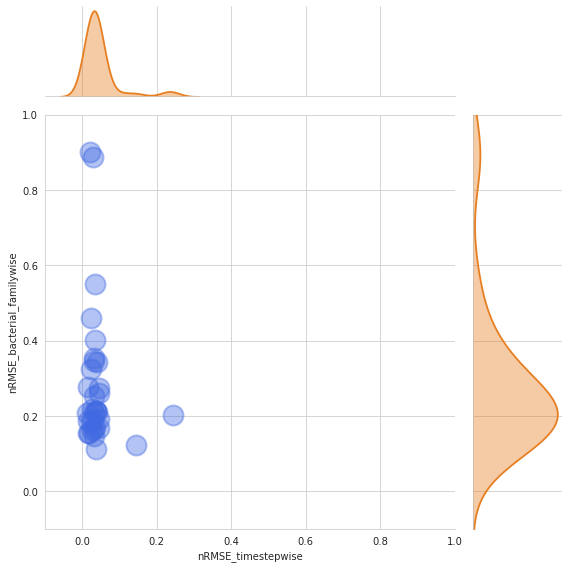

In [21]:
g = sns.JointGrid(
    x=heatmap_nrmse['nRMSE_timestepwise'],
    y=heatmap_nrmse['nRMSE_bacterial_familywise'], 
    data = heatmap_nrmse,
    height = 8,
    ratio = 4,
    xlim = -0.1,
    ylim = -0.1
)

g.plot_joint(
    sns.scatterplot,
    ec="face",
    s=400,
    alpha=.4,
    color = 'royalblue',
    linewidth=2
)

g.plot_marginals(
    sns.kdeplot,
    fill=True,
    alpha=.4,
    linewidth=1.8,
    color = '#e67e22'
)
#plt.title('Normalized RMSE for each timestep and bacterial family - VAR model lag 2')
plt.savefig('NRMSE.png',
            bbox_inches='tight')
#sns.set_theme()
#g.plot_joint(sns.jointplot)

TRUE = TRUE_SEQUENCE.copy()
FORECAST = sVAR_1_PREDICTION.copy()

#change to binary
TRUE[TRUE > float(0.83)] = 1 #treat values that are smaller than 0.1% of max value as 0
FORECAST[FORECAST > float(0.83)] = 1

for col in TRUE.columns.tolist():
    
    T = TRUE[col]
    F = FORECAST[col]
    f1_s = f1_score(T, F) 

# PLOT FORECAST

In [19]:
predicted = sVAR_1_PREDICTION
predicted['type'] = 'var_2'
predicted['timestep'] = [i for i in range(378, 418)]

true = TRUE_SEQUENCE
true['type'] = 'true'
true['timestep'] = [i for i in range(378, 418)]

naive = NAIVE_FORECAST_SEQUENCE
naive['type'] = 'naive_forecast'
naive['timestep'] = [i for i in range(378, 418)]

In [20]:
plot_true_pred = true.append(predicted).append(naive)
plot_true_pred = plot_true_pred.reset_index().drop(['index'], axis = 1)

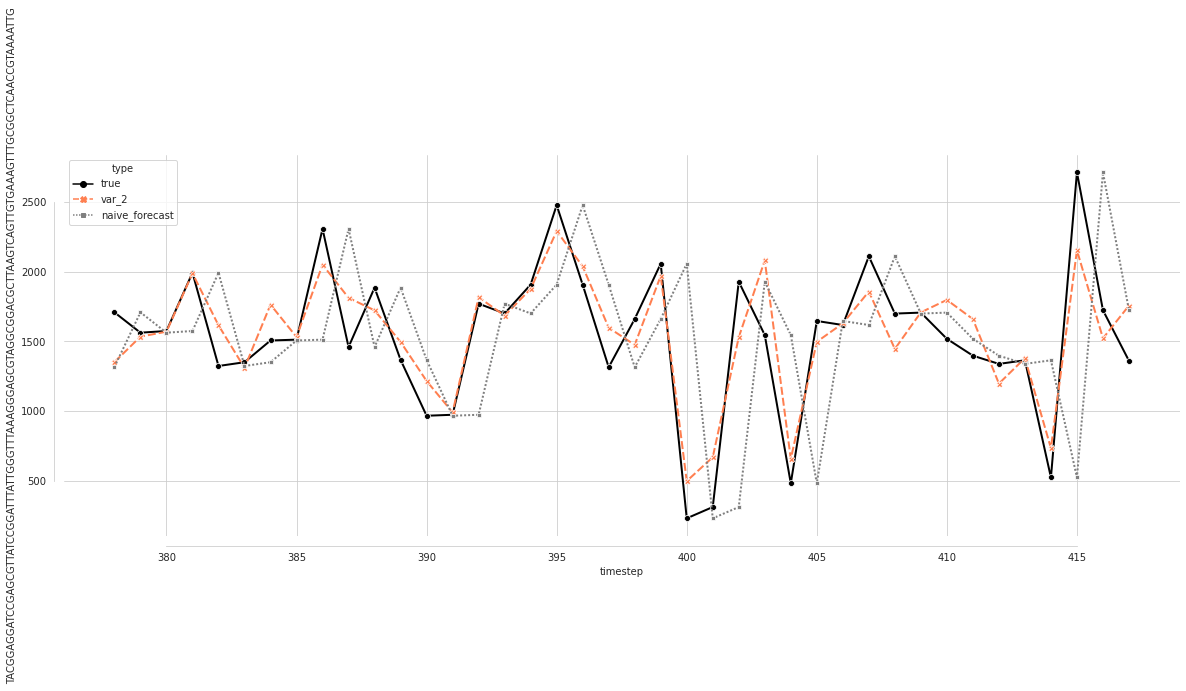

In [21]:
plt.figure(figsize=(20,7))

cmap = ['black','coral', 'grey']

sns.lineplot(x = plot_true_pred['timestep'],
             y = plot_true_pred.iloc[:,1], #first column
             hue = 'type',
             data = plot_true_pred,
             style = 'type', 
             markers = True,
            palette = cmap, 
            linewidth = 2)
    
sns.despine(offset=10,
                trim=True)

plt.savefig('svar2_forecast.png', bbox_inches='tight')

# PROCRUSTES

In [25]:
pred_df = pd.read_csv('PROCRUSTES_ANALYSIS/svar_bc_matrix.tsv', sep = '\t', index_col = [0])
true_df = pd.read_csv('PROCRUSTES_ANALYSIS/true_bc_matrix.tsv', sep = '\t', index_col = [0])

In [26]:
true_ordination = skbio.stats.ordination.pcoa(true_df.values)#, number_of_dimensions=3)
pred_ordination = skbio.stats.ordination.pcoa(pred_df.values)#, number_of_dimensions=3)

true_ordination_samples = true_ordination.samples
predicted_ordination_samples = pred_ordination.samples

#once again procustes
x, y, disparity = procrustes(true_ordination_samples, predicted_ordination_samples)

/home/MCB/zkarwowska/anaconda3/envs/skbio_ml/lib/python3.9/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.022445238832077503 and the largest is 1.501103675585445.
  warn(
/home/MCB/zkarwowska/anaconda3/envs/skbio_ml/lib/python3.9/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section

/home/MCB/zkarwowska/anaconda3/envs/skbio_ml/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/MCB/zkarwowska/anaconda3/envs/skbio_ml/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


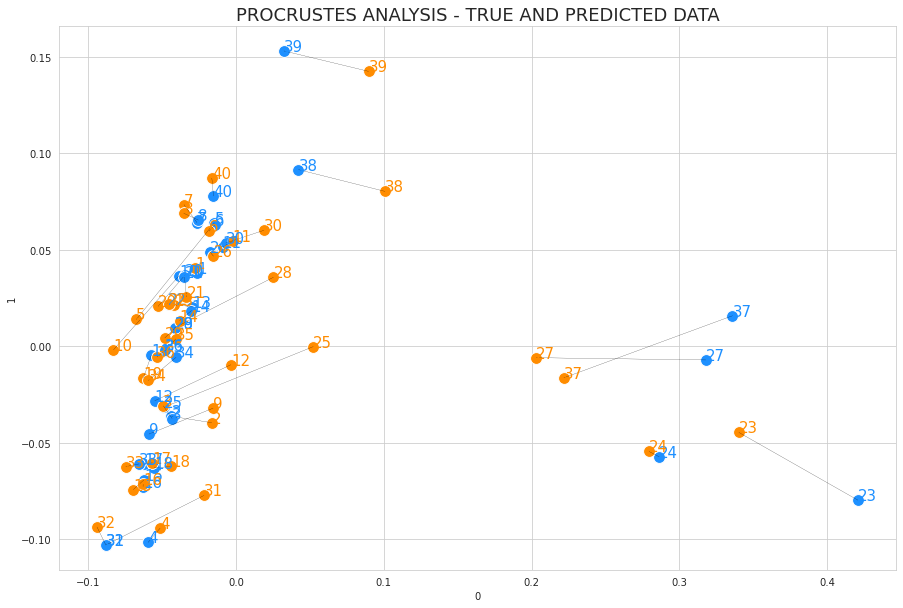

In [48]:
X = pd.DataFrame(x)
Y = pd.DataFrame(y)

fig = plt.figure(figsize=(15,10))

ax = sns.scatterplot(X[0],X[1],
                     s=140,
                     color = 'dodgerblue',
                     marker="o")

ax = sns.scatterplot(Y[0], Y[1],
                     s=140,
                     color = 'darkorange',
                     marker="o")

for i, t in zip(range(0, 40), TRUE_SEQUENCE.index):
    plt.text(x=X[0][i], y=X[1][i],
             s=t,
             color = 'dodgerblue',
             size = 15)
    
    plt.text(x=Y[0][i], y=Y[1][i],
             s=t,
             color = 'darkorange',
             size = 15)
    
for i in range(0, 40):
    
    x_coord = [X[0][i], Y[0][i]]
    y_coord = [X[1][i], Y[1][i]]


    plt.plot(x_coord, y_coord, color = 'black', linewidth = 0.2)
    
plt.title('PROCRUSTES ANALYSIS - TRUE AND PREDICTED DATA',
#plt.title('PROCRUSTES ANALYSIS - TRUE AND PREDICTED DATA. Disparity = {:.2f}'.format(disparity),
          fontsize = 18)
plt.savefig('PROCRUSTES_ANALYSIS/procrustes_svar1.png', bbox_inches='tight')
plt.show()

